### $$\text{Lab 2: TRANSFER LEARNING (GRADED)}$$


#### $$\text{Problem: Fine-tuning a Pre-trained VGG16 Model for Multiclass Food Classification}$$

## **Importing basic Libraries**

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping

## **0.0.1 Data download**

In [75]:
import os
import requests
import zipfile
def download_and_unzip_data(url, destination_folder):
    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)
    # Extract the filename from the URL
    file_name = os.path.basename(url)
    # Define the path to save the downloaded zip file
    save_path = os.path.join(destination_folder, file_name)
    try:
    # Send an HTTP GET request to download the zip file
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception if the request was␣not successful
    # Save the downloaded zip file
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        # Unzip the downloaded file
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)
        print(f"File downloaded and unzipped to {destination_folder}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download the file: {str(e)}")


In [76]:
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
destination_folder = "/content/dataset2" # TODO: Change this to your desired destination folder
# TODO: Call download_and_unzip_data and download the data

In [77]:
download_and_unzip_data(url, destination_folder)

File downloaded and unzipped to /content/dataset2


## **0.0.2 IMAGE PREPROCESSING and Data Augmentation**

In [78]:
train_dir = '/content/dataset2/101_food_classes_10_percent/train' # TODO: Change the directory to train folder
test_dir = '/content/dataset2/101_food_classes_10_percent/test' # TODO: Change the directory to test folder
# Make sure to give path of folder not file

In [79]:
import os
# Function to count files in a directory
def count_files_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count
# Count the number of images in the train and test sets
num_train_images = count_files_in_directory(train_dir)
num_test_images = count_files_in_directory(test_dir)
# Print the counts
print(f"Number of images in the train set: {num_train_images}")
print(f"Number of images in the test set: {num_test_images}")

Number of images in the train set: 7575
Number of images in the test set: 25250


In [80]:
train_datagen = ImageDataGenerator(
    rotation_range = 40, # TODO: Rotation range -> 40,
    width_shift_range = 0.2, # TODO: Width shift range -> 0.2,
    height_shift_range = 0.2, # TODO: Height shift range -> 0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
validation_split=0.2) # set validation split

In [81]:
class_subset = sorted(os.listdir(os.path.join(destination_folder,'101_food_classes_10_percent/train')))[:10]
BATCH_SIZE = 64 # TODO: Define batch size of your choice
IMG_SHAPE = (224, 224, 3)
traingen = train_datagen.flow_from_directory(train_dir,
                                              target_size = (224, 224), # target_size= # TODO: Define image size,
                                              class_mode='categorical',
                                              classes=class_subset,
                                              subset='training',
                                              batch_size = 64, # TODO: BATCH SIZE,
                                              shuffle = True, # TODO: Shuffle dataset,
                                              seed = 42 # TODO: Set the seed
                                            )

# TODO: Define valdgen for the validation set. Hint: traingen
validgen = train_datagen.flow_from_directory(train_dir,
                                              target_size = (224, 224), # target_size= # TODO: Define image size,
                                              class_mode='categorical',
                                              classes=class_subset,
                                              subset='validation',
                                              batch_size = 64, # TODO: BATCH SIZE,
                                              shuffle = True, # TODO: Shuffle dataset,
                                              seed = 42 # TODO: Set the seed
                                            )


testgen = ImageDataGenerator().flow_from_directory(test_dir,
                                                    target_size = (224, 224), # target_size= # TODO: Define image size,
                                                    class_mode=None,
                                                    classes=class_subset,
                                                    batch_size=1,
                                                    shuffle=False,
                                                    seed=42
                                                   )

Found 600 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## **0.0.3 Preprocess VGG16**

In [82]:
from keras.applications.vgg16 import preprocess_input
preprocess_input = preprocess_input
# preprocess_input = TODO: Initial VGG16 Preprocess Hint: libraries

In [83]:
# TODO: Download weights of VGG16 model.
base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = IMG_SHAPE, classes = 10 )
# TODO: Freeze the trainable parameters
# base_model.trainable = # TODO: Freeze the weights
base_model.trainable = False
image_batch, label_batch = next(iter(traingen))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 512)


In [84]:
# Let's take a look at the base model architecture
# TODO: Print the architecture of base model and get the intuition
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## **0.0.4 Architecture**

In [85]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs) # x = # TODO: Preprocess the input by VGG16 Preprocessor
x = base_model(x) # x = # TODO: Initialize the base_model and pass the preprocessed data
x = tf.keras.layers.Flatten()(x) # x = tf.keras.layers. # TODO Flatten the data
x = tf.keras.layers.Dense(4096, activation = 'relu')(x) # x = # TODO: Apply Dense layer with 4096 neurons and relu activation
x = tf.keras.layers.Dense(1072, activation = 'relu')(x) # x = # TODO: Apply Dense layer with 1072 neurons and relu activation
x = tf.keras.layers.Dropout(0.2)(x) # x = # TODO: Apply Dropout layer with 0.2 for dropout value
x = tf.keras.layers.Dense(10, activation = 'softmax')(x) # x = # TODO: Apply softmax for prediction Hint: what shoould be number of neurons in it?
# NOTE: Sequential, .add(...) will not work. We need fully connected network. Hint ()(input)
model = tf.keras.Model(inputs, x) # model = tf.keras.Model(inputs, outputs)

In [86]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 4096)              1027

In [87]:
# Create an instance of the Adam optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.001)
# Compile your model with the custom optimizer, categorical cross entropy loss and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1)

In [88]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
patience=10,
restore_best_weights=True,
mode='min')

In [89]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/modelWeights4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)
# checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', monitor='val_loss', save_best_only=True, mode='auto')


# n_epochs = # TODO: DEFINE NO OF EPOCHS
vgg_history = model.fit(traingen,
batch_size=BATCH_SIZE,
epochs=15,
validation_data=validgen,
callbacks=[early_stop, checkpoint],
verbose=1)

Epoch 1/15
10/10 [==============================] - ETA: 0s - loss: 177.4477 - accuracy: 0.1450
Epoch 1: val_loss improved from inf to 48.19104, saving model to /content/modelWeights4/cp.ckpt
10/10 [==============================] - 34s 3s/step - loss: 177.4477 - accuracy: 0.1450 - val_loss: 48.1910 - val_accuracy: 0.2000
Epoch 2/15
10/10 [==============================] - ETA: 0s - loss: 21.6143 - accuracy: 0.2300
Epoch 2: val_loss improved from 48.19104 to 6.21735, saving model to /content/modelWeights4/cp.ckpt
10/10 [==============================] - 29s 3s/step - loss: 21.6143 - accuracy: 0.2300 - val_loss: 6.2174 - val_accuracy: 0.4600
Epoch 3/15
10/10 [==============================] - ETA: 0s - loss: 5.5997 - accuracy: 0.4417
Epoch 3: val_loss improved from 6.21735 to 2.33079, saving model to /content/modelWeights4/cp.ckpt
10/10 [==============================] - 28s 3s/step - loss: 5.5997 - accuracy: 0.4417 - val_loss: 2.3308 - val_accuracy: 0.4800
Epoch 4/15
10/10 [===========

In [90]:
os.listdir(checkpoint_dir)

['cp.ckpt']

In [91]:
import matplotlib.pyplot as plt
def plot_training_history(history):
  """
  Plots the training and validation accuracy and loss curves from a training history object.
  Parameters:
  - history: A training history object containing 'accuracy', 'loss', 'val_accuracy', and 'val_loss' values.
  """
  # Plot training & validation accuracy values
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'], loc='upper left')
  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.tight_layout()

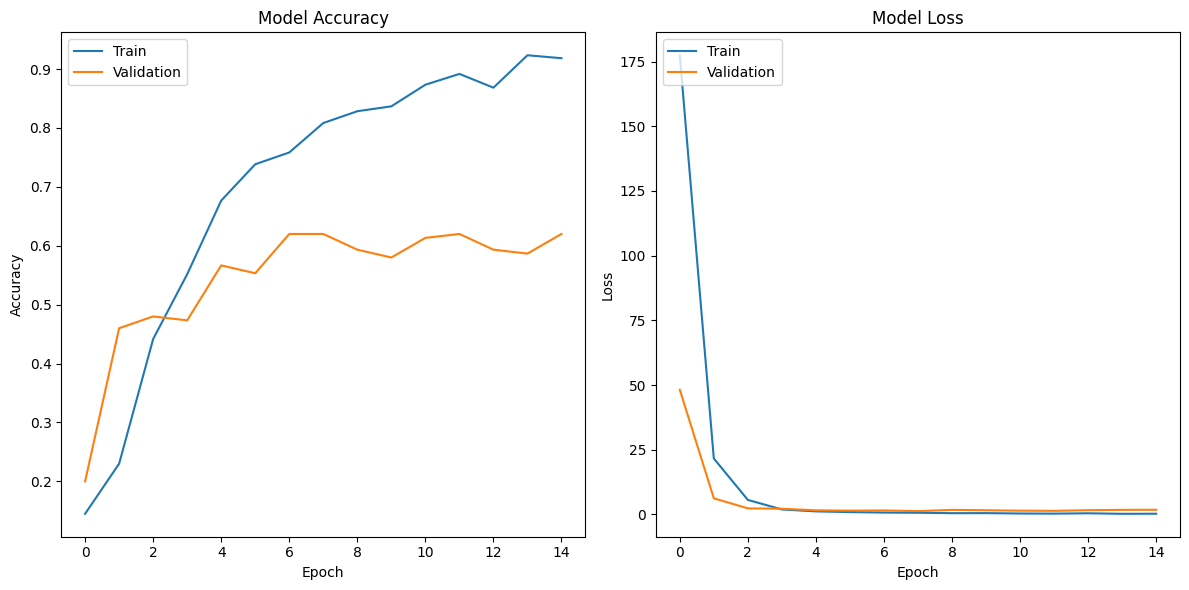

In [92]:
plot_training_history(vgg_history)

In [93]:
# sample = test_gen
vgg_preds = model.predict(testgen) # Generate predictions
# vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
# vgg_preds = # Make prediction on test dataset
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

2500/2500 [==============================] - 26s 10ms/step


In [94]:
from sklearn.metrics import accuracy_score
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 68.52%


## **0.0.5 Fine Tuning**

In [95]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()
# TODO: Make the model weights trainable
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the model: ", len(model.layers))

Number of layers in the model:  9


In [96]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 4096)              1027

In [97]:
# Fine-tune from this layer onwards
# fine_tune_at = # Define after how many layers we need to make weights trainable
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:10]:
  layer.trainable = False
  # print(layer.name)

In [98]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 4096)              1027

In [99]:
# Retrain model with fine-tuning
# TODO Fit the fine tuned model on train and validation set, do apply early stopping
# callbacks=[checkpoint]
model.load_weights(checkpoint_path)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['accuracy'])
vgg_fine_tune_history = model.fit(traingen,
batch_size=BATCH_SIZE,
epochs=15,
validation_data=validgen,
callbacks=[early_stop],
verbose=1,
)

Epoch 1/15
10/10 [==============================] - 15s 1s/step - loss: 377.4727 - accuracy: 0.1833 - val_loss: 24.9101 - val_accuracy: 0.1000
Epoch 2/15
10/10 [==============================] - 12s 1s/step - loss: 6.8465 - accuracy: 0.0833 - val_loss: 2.6792 - val_accuracy: 0.1267
Epoch 3/15
10/10 [==============================] - 12s 1s/step - loss: 2.8342 - accuracy: 0.1083 - val_loss: 2.4292 - val_accuracy: 0.1000
Epoch 4/15
10/10 [==============================] - 12s 1s/step - loss: 2.5349 - accuracy: 0.1067 - val_loss: 2.3846 - val_accuracy: 0.1000
Epoch 5/15
10/10 [==============================] - 12s 1s/step - loss: 2.3253 - accuracy: 0.1050 - val_loss: 2.3054 - val_accuracy: 0.1133
Epoch 6/15
10/10 [==============================] - 13s 1s/step - loss: 2.3137 - accuracy: 0.0967 - val_loss: 2.3006 - val_accuracy: 0.1267
Epoch 7/15
10/10 [==============================] - 12s 1s/step - loss: 2.3079 - accuracy: 0.0917 - val_loss: 2.3045 - val_accuracy: 0.1133
Epoch 8/15
10/10 

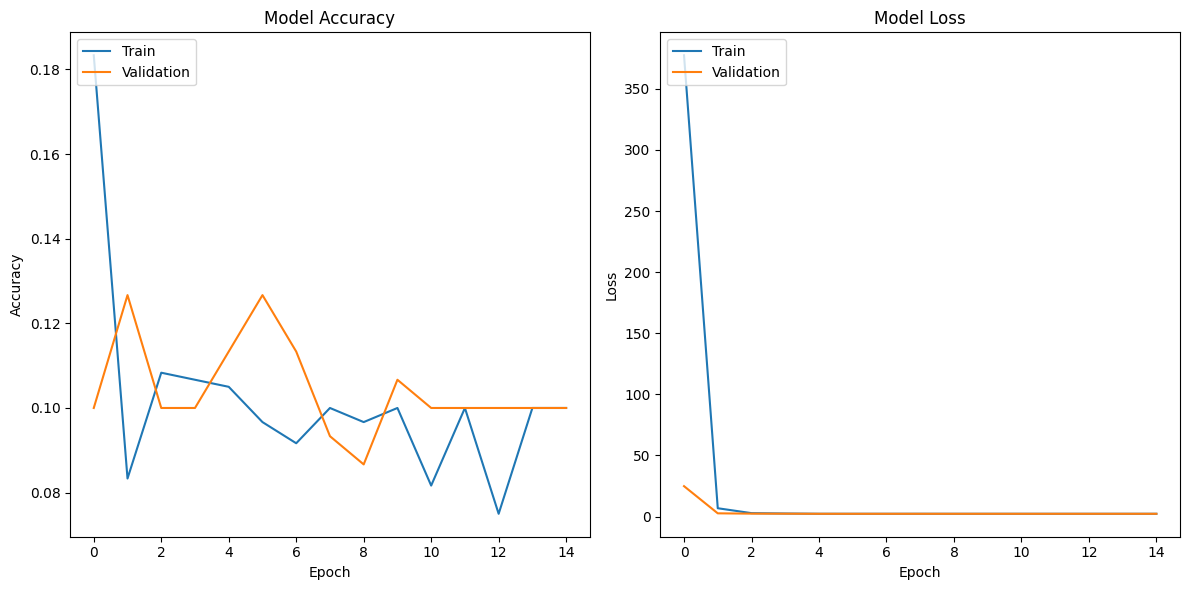

In [103]:
plot_training_history(vgg_fine_tune_history)

In [101]:
# Generate predictions
# vgg_model_ft.load_weights('tl_model_v1_ft.weights.best.hdf5') # initialize the best trained weights
vgg_preds_ft = model.predict(testgen)
# vgg_pred_classes_ft = # TODO Make prediction on fine tuned model

# sample = test_gen
vgg_preds = model.predict(testgen) # Generate predictions
# vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights
fine_tune_true_classes = testgen.classes
fine_tune_class_indices = traingen.class_indices
fine_tune_class_indices = dict((v,k) for k,v in class_indices.items())
# vgg_preds = # Make prediction on test dataset
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

2500/2500 [==============================] - 26s 10ms/step


In [ ]:
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Get the names of the ten classes
class_names = testgen.class_indices.keys()
def plot_heatmap(y_true, y_pred, class_names, ax, title):
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(
cm,
annot=True,
             square=True,
xticklabels=class_names,
yticklabels=class_names,
fmt='d',
cmap=plt.cm.Blues,
cbar=False,
ax=ax
)

ax.set_title(title, fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_heatmap(true_classes, vgg_pred_classes, class_names, ax1, title="Transfer Learning (VGG16) No Fine-Tuning")
plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax2,␣
↪title="Transfer Learning (VGG16) with Fine-Tuning")
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
# Plot the predictions with labels